## Some imports

In [341]:
import numpy as np
import sympy as sp
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [342]:
gaps = []

## frank-wolfe algorithm

In [343]:
def f(Q, q, x):
    return (1/2 * x.T @ Q @ x + q.T @ x)[0][0]

def frank_wolfe(Q, q, x0, partitions, max_iter=100, eps=1e-6, interactive=False, verbose=False, step_size='hyperbolic'):
    x = x0
    for k in range(max_iter):
        # Compute the gradient
        grad = Q @ x + q

        s = np.zeros_like(q) # direction vector
        for part in partitions:
            if len(part) == 0:
                continue

            min_index = part[np.argmin(grad[part])]
            s[min_index] = 1
            

        # Compute the step size
        if step_size == 'hyperbolic':
            alpha = 2 / (k + 2)
        elif step_size == 'exact':
            alpha = - ((np.dot(q.T, (s - x)) + np.dot((s - x).T, Q @ x)) / np.dot((s - x).T, (Q @ (s - x))))[0][0] 
            if alpha > 1:
                alpha = 1  
   
        # Update the solution
        x_new = (1 - alpha) * x + alpha * s
        
        # Compute Frank–Wolfe gap
        gap = np.dot(grad.T, (x - s))[0][0]
        gaps.append(gap)
        if gap <= eps:
            print(f"Stopping criterion reached (gap ≤ {eps}).")
            break
        
        if verbose:
            print(f"Iteration {k}:")
            # print(f"x = \n{x}")
            # print(f"s = \n{s}")
            # print(f"s_index = {np.where(s == 1)[0]}")
            # print(f"f(x) = \n{f(Q, q, x)}")
            # print(f"gradient_norm = {np.linalg.norm(grad)}\n")
            print(f"alpha = {alpha}")
            print(f"gap = {gap}\n")
        
        x = x_new
       

        if interactive:
            input("Press Enter to continue...")
    
    return x

## generate Q matrix

In [344]:
# Generate a random square matrix
n = 100  # Size of the matrix
matrix = np.random.rand(n, n)
# matrix = matrix * np.random.randint(1, 10)

Q = (matrix.T @ matrix + 3 * np.eye(n)).astype(np.float64)  # Ensure positive definiteness
q = np.random.rand(n, 1).astype(np.float64)

eigenvalues = np.linalg.eigvals(Q)
eigenvalues = sorted(eigenvalues, reverse=True)

sp.init_printing(use_latex=True)
dispQ = sp.Matrix(Q)
dispq = sp.Matrix(q)
dispeig = sp.Matrix(eigenvalues)
# print("Q:")
# display(dispQ)
# print()
# print("q:")
# display(dispq)
# print()
# print("Eigenvalues of Q:")
# display(dispeig)

In [345]:
# import plotly.graph_objects as go

# # Define the grid for plotting
# x_vals = np.linspace(0, 1, 100)
# y_vals = np.linspace(0, 1, 100)
# X, Y = np.meshgrid(x_vals, y_vals)

# # Compute Z values for the function f
# Z = np.zeros_like(X)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         x_vec = np.array([[X[i, j]], [Y[i, j]]])
#         Z[i, j] = f(Q, q, x_vec)

# # Create the 3D surface plot
# fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

# # Add labels and title
# fig.update_layout(
#     title="3D Plot of the Function f",
#     scene=dict(
#         xaxis_title="x1",
#         yaxis_title="x2",
#         zaxis_title="f(x)"
#     )
# )

# # Display the interactive plot
# fig.show()


## Generate constraints

In [346]:
n_partitions = np.random.randint(1, n//2)
partitions = [[] for i in range(n_partitions)]
index = np.random.permutation(n)
for i in range(2*n_partitions):
    partitions[i % n_partitions].append(index[i])

# distribute the other elements randomly
for i in range(2*n_partitions, n):
    partitions[np.random.randint(0, n_partitions)].append(index[i])

print(f"Partitions amount: {n_partitions}")
for i in range(n_partitions):
    print(partitions[i])

Partitions amount: 47
[85, 82]
[26, 97]
[28, 99]
[3, 57]
[23, 88]
[84, 7]
[59, 58]
[30, 21, 43]
[9, 71]
[19, 8]
[78, 80]
[29, 35]
[22, 33]
[34, 83]
[89, 52]
[48, 49]
[93, 24]
[14, 65, 55]
[6, 79]
[63, 42]
[81, 12]
[10, 75]
[16, 53]
[92, 37]
[77, 13]
[70, 69]
[2, 5]
[96, 86]
[27, 54]
[76, 4, 62]
[44, 61]
[91, 73]
[17, 87]
[64, 0]
[60, 72, 20]
[74, 51]
[41, 39]
[15, 95]
[18, 11, 31]
[98, 67]
[25, 46]
[66, 40]
[47, 94]
[90, 1]
[38, 68]
[45, 56]
[32, 50, 36]


## Starting point

In [347]:
x0 = np.zeros((n, 1), dtype=np.float64)
for part in partitions:
    if len(part) == 0:
        continue
    x0[np.random.choice(part)] = 1
print("x0:")
dispx0 = sp.Matrix(x0)
# display(dispx0)

x0:


## Optimization

Step type: hyperbolic
Elapsed time: 1.16 seconds
Step type: exact
Elapsed time: 1.22 seconds


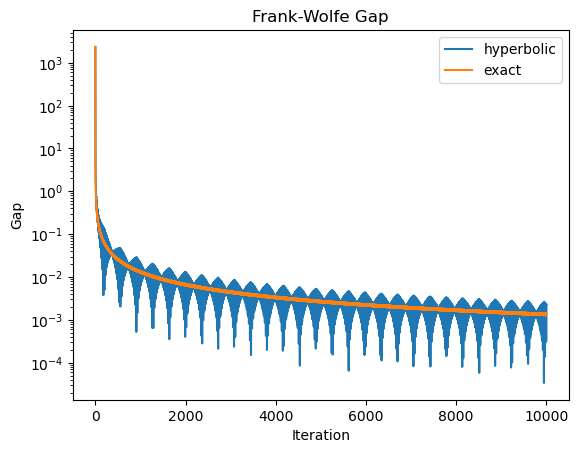

In [348]:
gaps = []

for step_type in ("hyperbolic", "exact"):
    gaps = []
    print(f"Step type: {step_type}")
    t0 = time.time()
    x_star = frank_wolfe(Q, q, x0, partitions, max_iter=10000, eps=1e-8, interactive=False, verbose=False, step_size=step_type)
    t1 = time.time()
    print(f"Elapsed time: {t1 - t0:.2f} seconds")

    # print("x_star:")
    # dispx_star = sp.Matrix(x_star)
    # display(dispx_star)

    # plot
    plt.plot(gaps, label=step_type)
    plt.xlabel("Iteration")
    plt.ylabel("Gap")
    plt.title("Frank-Wolfe Gap")
    plt.yscale("log")
    plt.legend()
    plt.grid()

plt.show()

In [349]:
# for part in partitions:
#     print(sum(x_star[part]))

## Comparison with a solver

Elapsed time: 0.41 seconds

Plotting convergence history...


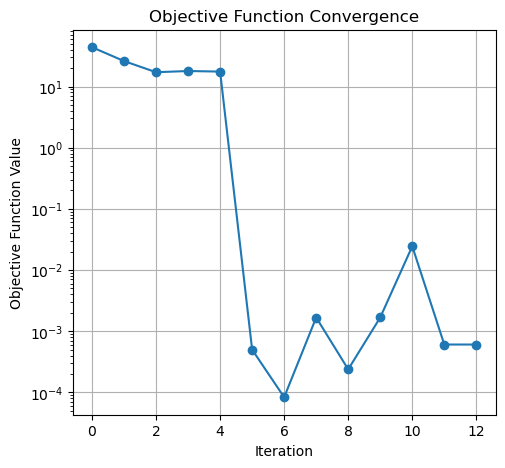

In [350]:

# objective function f(x) = 1/2 x^T Q x + q^T x
def objective(x):
    return 0.5 * x @ (Q @ x) + q.flatten() @ x

# bounds 0 ≤ x_i ≤ 1
bounds = [(0, 1)] * n

# for each partition, the sum of the x's in that block must be 1
constraints = [
    {'type': 'eq', 'fun': lambda x, part=part: x[part].sum() - 1}
    for part in partitions
]

x0_flat = x0.flatten()

# Lists to store convergence data
iteration_history = []
objective_history = []
gap_history = []
call_count = 0 # To track the iteration number

def my_callback(xk):
    """Callback function called after each iteration."""
    global call_count # Need global to modify the counter
    global iteration_history, objective_history, constraint_violation_history
    # Ensure objective and partitions are accessible from here (they should be if defined globally or in the same scope)

    # Record iteration number
    iteration_history.append(call_count)
    call_count += 1 # Increment for the next call

    # Compute the gradient
    xk = xk.reshape(-1, 1)  # Reshape xk to be a column vector
    grad = Q @ xk + q
    s = np.zeros_like(q)
    for part in partitions:
        min_index = part[np.argmin(grad[part])]
        s[min_index] = 1

    # Compute Frank–Wolfe gap
    gap = np.dot(grad.T, (xk - s))[0][0]
    gap_history.append(gap)

t0 = time.time()

res = minimize(objective,
                x0_flat,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                callback=my_callback,
                tol=1e-20,
)

t1 = time.time()
print(f"Elapsed time: {t1 - t0:.2f} seconds")

print("\nPlotting convergence history...")

if iteration_history: # Only plot if callback was called at least once
    plt.figure(figsize=(12, 5))

    # Plot Objective Function Value
    plt.subplot(1, 2, 1)
    plt.plot(iteration_history, gap_history, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Objective Function Convergence")
    plt.grid(True)
    plt.yscale('log')
else:
    print("No convergence history recorded (callback might not have been triggered).")


Solver status: Positive directional derivative for linesearch
Objective value: 26444.20118276273
Our value: 26444.201852389626
x (solver):


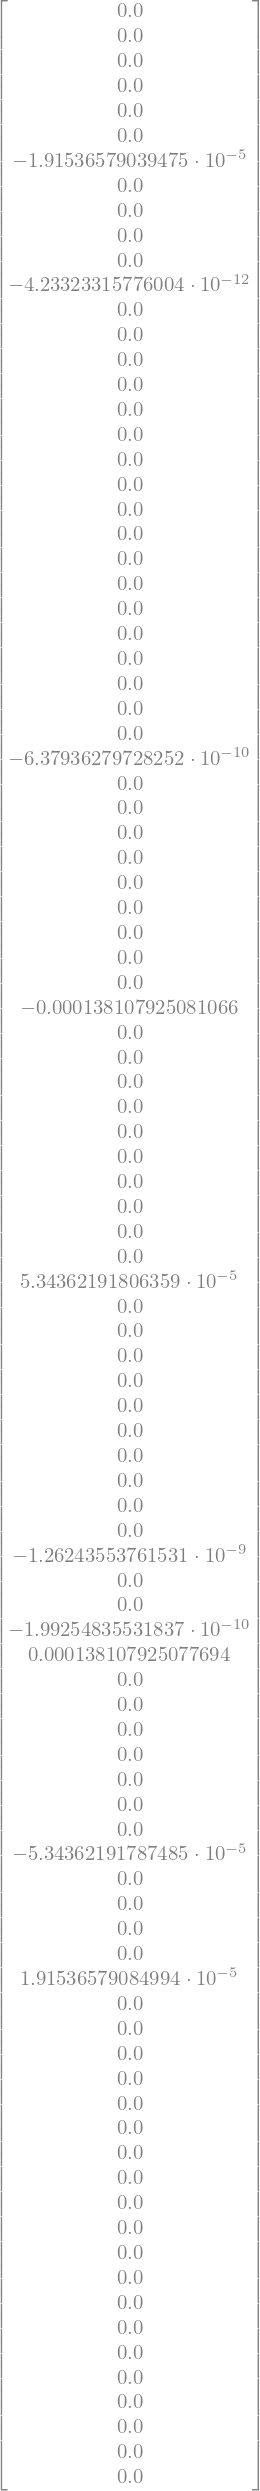

In [351]:
# reshape solution
x_solver = res.x.reshape(-1, 1)

# Set precision for displaying results
precision = 4  # Change this value to adjust precision
np.set_printoptions(precision=precision, suppress=True)

print("Solver status:", res.message)
print("Objective value:", res.fun)
print(f"Our value: {f(Q, q, x_star)}")
print("x (solver):")
diff = x_star - x_solver
display(sp.Matrix(diff))